# wk6 Demo - Supervised Learning & Gradient Descent
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Spring 2019`__

In Supervised Machine Learning we use labeled training data to learn a decision function (a.k.a 'model') and make evaluations about how well that decision function might perform when applied to new data. Of course the biggest factor that will determine the performance of your model is the quality of the data you train on. However another key challenge is the question of what models to consider & how to compare their performance so that you can choose the best one. Gradient Descent solves this challenge for a certain class of functions. By the end of this live session you should be able to:
* __... define__ the loss function for OLS Regression and its gradient.
* __... explain__ the relationship between model space and parameter space.
* __... recognize__ convex optimization problems and why they are desirable.
* __... describe__ the process of Gradient Descent & how it can be parallelized.


# Introduction

In today's demo, we'll use Linear Regression on a simple example in order to explore key topics related to distributed learning of parametric models. Broadly speaking, the supervised learning of a parametric model can be split into to two components:

1. **Optimization Task (a.k.a. Learning)**: Given a strategy for making a prediction, return the specific parameters which guarantee the optimal prediction.   
2. **Prediction Task**: Given an input vector, return an output value.


> __DISCUSSION QUESTION:__ _In the case of Linear Regression, which of the two tasks above are we most likely to want to parallelize? Why?_
* The Optimization Task - might be interview question


OK, Let's start with a quick review of some notation you will have seen in w207. 

## Notation Review

Linear Regression tackles the __prediction task__ by assuming that we can compute our output variable, $y$, using a linear combination of our input variables. That is we assume there exist a set of **weights**, $\mathbf{w}$, and a **bias** term, $\mathbf{b}$, such that for any input $\mathbf{x}_j \in \mathbb{R}^m$:

\begin{equation}\tag{1.1}
y_j = \displaystyle\sum_{i=1}^{m}{w_i\cdot x_{ji} + b}
\end{equation}

In vector notation, this can be written:

\begin{equation}
y_j = \displaystyle{\mathbf{w}^T\mathbf{x}_{j} + b}
\end{equation}

Of course, this perfect linear relationship never holds over a whole dataset **$X$**, so Linear Regression attempts to fit (i.e. **learn**) the best line (in 1 dimension) or hyperplane (in 2 or more dimensions) to the data.  In the case of **ordinary least squares (OLS)** linear regression, best fit is defined as minimizing the Euclidean distances of each point in the dataset to the line or hyperplane.  These distances are often referred to as **residuals**. 

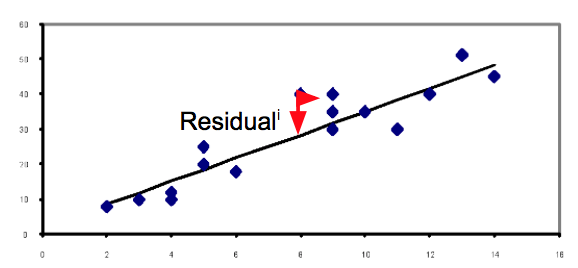

In [1]:
from IPython.display import Image
Image(filename="residual.png", width="400", height="200")

The calculation of the average residual (a.k.a.**mean squared error, MSE**) over our test or training set allows us to measure how good a fit we've achieved. We call this function the **loss** or **objective** function because our goal in the **optimization task** is to find the parameters which minimize it. (Ok, yes, _technically_ MSE is _not actually equal_ to the average residual but it is conceptually equivalent & guaranteed to have the same minimum.)

\begin{equation}\tag{1.2}
f(\mathbf{w}, b) = \frac{1}{n}\sum_{j=1}^{n}\left[ (\mathbf{w}^T\mathbf{x}_j + b) - y_i\right]^2,\\
n = \left|X_{\text{train}}\right|
\end{equation}

For convenience, we sometimes choose to think of the bias $b$ as weight $w_{m+1}$. To operationalize this, we'll _augment_ our input vectors by setting $x_{m+1}=1$. This gives us a simpler way to write the loss function:
$$
\mathbf{x}' :=
\begin{bmatrix}
\mathbf{x}\\
1
\end{bmatrix},\quad
\boldsymbol{\theta} :=
\begin{bmatrix}
\mathbf{w}\\
b
\end{bmatrix}
$$

\begin{equation}\tag{1.3}
f(\boldsymbol{\theta}) = \frac{1}{n}\sum_{i=1}^{n}\left[ \boldsymbol{\theta}^T\cdot\mathbf{x}'_i - y_i\right]^2
\end{equation}

Machine Learning packages like `sklearn` and `tensorflow` take this one step further by representing the entire training set in a single matrix were each row is an input vector and each column represents a feature:
$$
\text{X}' =
\begin{bmatrix}
\mathbf{x'}_1^{\text{T}}\\
\vdots\\
\mathbf{x'}_n^{\text{T}}
\end{bmatrix},\quad
\mathbf{y} = 
\begin{bmatrix}
y_1\\
\vdots\\
y_n
\end{bmatrix}
$$

\begin{equation}\tag{1.4}
f(\boldsymbol{\theta}) = \frac{1}{n}\|\text{X}'\cdot \boldsymbol{\theta} - \mathbf{y}\|_2^2
\end{equation}

As you see here, it is customary to write loss as a function of the parameters $\theta$ (or equivalently $\mathbf{w}$ and $b$). However it is important to note that the MSE loss depends on both the parameters/weights  _and_ the data $X$, we'll talk more about that later.

> __DISCUSSION QUESTIONS:__ 
* _In equation 1.1 what do $x_{ji}$, $w_i$, and $\mathbf{w}$ each represent?_  
* _In the asynch's version of the loss function $\alpha$ and $\beta$ appear as parameters... what do they represent? How are they captured in equations 1.2 and 1.3 respectively?_ 
* _If we were computing loss over a really large data set what might be the arguments in favor / against using the augmented version of the loss function calculation?_

### <--- SOLUTION --->
__INSTRUCTOR TALKING POINTS__  
* _In equation 1.1 what do $x_{ji}$, $w_i$, and $\mathbf{w}$ each represent?_ 
> $x_{ij}$ is the $i^{th}$ variable in the $j^{th}$ data example. $w_i$ is the $i^{th}$ weight (parameter), and $\mathbf{w}$ is the entire weight (parameter) vector.
* _In the asynch's version of the loss function $\alpha$ and $\beta$ appear as parameters... what do they represent? How are they captured in equations 1.2 and 1.3 respectively?_ 
>  TODO
* _If we were computing loss over a really large data set what might be the arguments in favor / against using the augmented version of the loss function calculation?_
> Having to augment the entire data set prior to learning adds an additional pass over the data. In addition, it doubles the storage required. Instead, we can "augment" each example as we encounter it.

#### A warning about OLS before we start:

Supervised learning models, especially interprable ones, and especially linear/logistic regression, tend to get used for two different kinds of tasks: prediction and inference -- it is important to remember the difference between these two use cases. While it is practically possible to fit a linear model to any dataset and then use that model to make predictions... it is _not_ always fair to use the coefficients of your model to infer relationships (causal or otherwise) between your features and outcome variable. As you will rememeber from w203 and w207 if you are going to perform inference using OLS, your data should satisfy the following conditions:
1. Residuals are homoscedastic - they have constant variance    
1. Residuals are normaly distributed
1. No multicolinearity - features are not correlated

## Notebook Set Up

In [2]:
# general imports
import sys
import csv
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# magic commands
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
# import helper modules
import helperFunc
import linRegFunc

# OPTIONAL - uncomment to print helper file docstrings
print(helperFunc.__doc__)
#print(linRegFunc.__doc__)


This file contains helper functions for generating, transforming
and plotting 2 dimensional data to use in testing & for ML demos.

Avaliable functions include:
    augment(X)
    plot2DModels(data, models=[], names = [], title=None)
    plotErrorSurface(data, weight_grid, loss, title=None)




# A Small Example

We'll start with a small example of 5 2-D points:

In [4]:
%%writefile fivePoints.csv
1,2
3,4
5,5
4,3
2,3

Writing fivePoints.csv


In [5]:
# load data from file
points = np.genfromtxt("fivePoints.csv", delimiter=',')

Here's what they look like next to a the simplest possible linear model:  $ y = x$

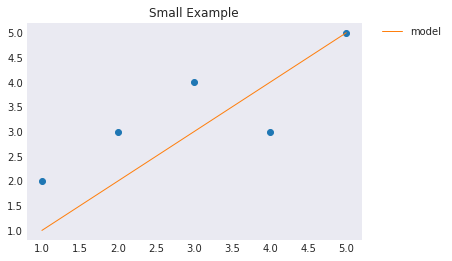

In [6]:
# easy plotting with a helper function
helperFunc.plot2DModels(points, [[1,0]],['model'], title = 'Small Example')

Looks reasonable, but its hard to gauge exactly how good a fit we have just by looking.

> __A TASK FOR YOU:__ Fill in the calculations below to compute the "Training Loss" for our data. These are easy and intuitive calculations that you will know from long-ago math classes... but instead of relying on your visual intuition, challenge yourself to think through these numbers in the context of our matrix equation for loss. Here it is again for your reference:
\begin{equation}\tag{1.3}
f(\boldsymbol{\theta}) = \frac{1}{n}\sum_{i=1}^{n}\left[ \boldsymbol{\theta}\cdot\mathbf{x}'_i - y_i\right]^2
\end{equation}

The parameter vector $\theta$ for our initial line $y=x$ is: 
$ \begin{bmatrix} ? \ \quad ? \ \end{bmatrix}$
         
The (augmented) data points $x_j$ are:
$ \begin{bmatrix} ? \\ ? \\ \end{bmatrix}$
$ \begin{bmatrix} ? \\ ? \\ \end{bmatrix}$
$ \begin{bmatrix} ? \\ ? \\ \end{bmatrix}$
$ \begin{bmatrix} ? \\ ? \\ \end{bmatrix}$
$ \begin{bmatrix} ? \\ ? \\ \end{bmatrix}$

Our loss calculations will be:

|$i$  | $y_i$ |   $\boldsymbol{\theta}\cdot\mathbf{x}'_i$ | $\left[ \boldsymbol{\theta}\cdot\mathbf{x}'_i - y_i\right]^2$ |
|:---:|:-----:|:----------------:|:------------------------:|
|     | true y   |   predicted y   |  squared residual       |
| 1   |       |                  |             |
| 2   |       |                  |    |
| 3   |       |                  |    |
| 4   |       |                  |    | 
| 5   |       |                  |    | 

 The training loss $f(\boldsymbol{\theta})$ for this data and these weights is: _______
 

In [7]:
# Run this cell to confirm your Hand Calculations
X = helperFunc.augment(points)[:,:-1]
y = points[:,-1]
print("Loss:", linRegFunc.OLSLoss(X, y,[1,0]))

Loss: 0.8


 > __DISCUSSION QUESTIONS:__ 
 * _What parts of this computation could be parallelized? What, if any, aggregation has to happen at the end?_ 
 * _What key-value format, partitioning, sorting would help? Could you use a combiner?_ 
 * _In addition to the data stream, what other information would your map or reduce tasks need access to?_ 

## Demo: Random Parameter Search.

Ok, so we know the model looks ok and we know its loss is $0.8$ but is that any good? A naive approach to "learning" a Linear Model might be to randomly generate a few more models and then pick the model with the lowest loss. Let's try it.

Best Random Model: [1, 0], Loss: 0.8


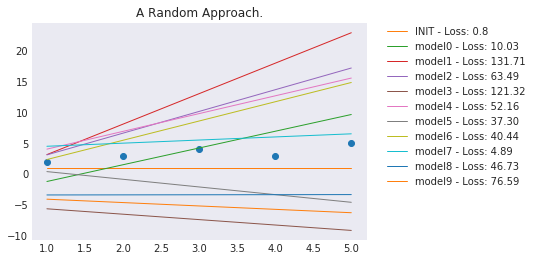

In [8]:
import helperFunc, linRegFunc

#################### Demo Parameters #################### 
# TRY CHANGING THESE & SEE HOW IT AFFECTS OUR SEARCH
NUM_MODELS = 10
PARAM_RANGE = [-5,5]

#################### Random Search Demo ####################
# Load & pre-process data
points = np.genfromtxt("fivePoints.csv", delimiter=',')
X = helperFunc.augment(points)[:,:2]
y = points[:,1]

# "Training"
models = [[0,1]]
names = ["INIT - Loss: 0.8"]
best = {'loss':0.8, 'W': [1,0]}
for idx in range(NUM_MODELS):
    # initialize a random weight vector w/ values in specified range
    W = np.random.uniform(PARAM_RANGE[0],PARAM_RANGE[1], size=(2))
    # compute loss & store for plotting
    loss = linRegFunc.OLSLoss(X, y, W)
    models.append(W)
    names.append("model%s - Loss: %.2f" % (idx, loss))
    # track best model
    if loss < best['loss']:
        best['loss'] = loss
        best['W'] = W
        
# Display Results
print(f"Best Random Model: {best['W']}, Loss: {best['loss']}")
helperFunc.plot2DModels(points, models, names, "A Random Approach.")

So, that was pretty poor. One idea would be to run a lot more iterations.

> __DISCUSSION QUESTION:__ _To what extent could parallelization help us redeem this approach? What exactly would you parallelize?_
* You can run lots of models and have a lot to choose from. You would parallelize getting these random model guesses.

## Demo: Systematic Brute Force.

For obvious reasons a more systematic approach is desirable. Instead of randomly guessing, let's use what we know to search an appropriate section of the the model space.

We can tell from the data that the linear model should probably have a fairly shallow positive slope and a positive intercept between 0 and 2. So lets initialize every possible combination of weights in that range up to a granularity of, say $0.2$, and compute the loss for each one.

Searched 100 models...
Best model: [0.6 1.6], Loss: 0.31999999999999984


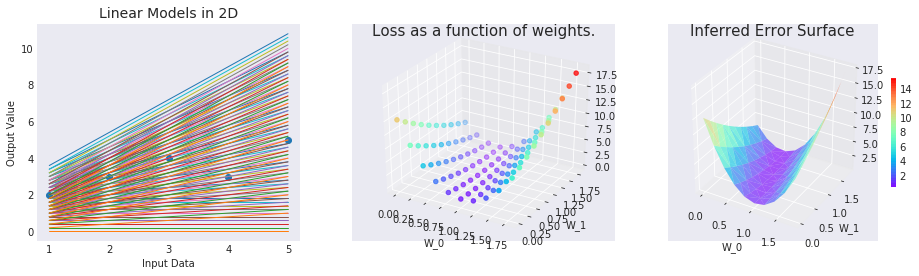

In [9]:
import helperFunc, linRegFunc

#################### Demo Parameters #################### 
# TRY CHANGING THESE & SEE HOW IT AFFECTS OUR SEARCH
W0_MIN = 0
W0_MAX = 2
W0_STEP = 0.2

W1_MIN = 0
W1_MAX = 2
W1_STEP = 0.2

#################### Grid Search Demo #################### 
### Load & Pre-process Data
points = np.genfromtxt("fivePoints.csv", delimiter=',')
X = helperFunc.augment(points)[:,:2]
y = points[:,1]

### "Training" 
# create a model for each point in our grid
grid = np.mgrid[W0_MIN:W0_MAX:W0_STEP,W1_MIN:W1_MAX:W1_STEP]
size = int(np.product(grid.shape)/2)
models = grid.reshape(2,size).T
# compute loss for each model
loss = []
for W in models:
    loss.append(linRegFunc.OLSLoss(X,y,W))
    
### Display Results
print(f"Searched {size} models...")
print(f"Best model: {models[np.argmin(loss)]}, Loss: {min(loss)}")
helperFunc.plotErrorSurface(points,models,loss)

> __DISCUSSION QUESTIONS:__ 
* _When we think about scaling up, is this still a better approach than guessing? How could it be parallelized?_ 
* _What would change about this approach if we had higher dimension data?_
* _In practice, when we're training Linear Models why don't we just look at the error surface and identify the lowest point?_
* _What about if we're training other kinds of models?_  

# Parameter Space, Gradients, and Convexity

As suggested by the systematic search demo, when we train parametric models we tend to switch back and forth between two different ways of visualizing our goal.

In [10]:
from IPython.display import HTML
HTML('<img src="./GD_gif/Gradient_Descent.gif">')

* When we look at a model next to our data represented in the Problem Domain Space, it is natural to think about loss as a measure of _**how far off the data are from our model**_. In other words, this visual suggests loss is a function of the training data $X$.
* By contrast, looking at an error surface plotted in Model Parameter Space, we intuitively see loss as an indicator of _**how far off the current model is from the optimal model**_. In other words, this view helps us think of loss as a function of the parameters $\theta$.

Of course in one sense, this distinction is just a matter of sematics. As we saw in equations 1.2, 1.3 and 1.4, MSE loss depends on _both_ the data and the parameters. However, in the context of 'inventing' ways to train a model, this distinction is a useful one. If we think of the data as fixed and focus on how loss varies _with respect to the parameters_, then we can take advantage of a little theory to speed up our search for the optimal parameters.

### Optimization Theory ... a short digression

Calculus gives us the simple solution to optimizing a real function. The **First Order Conditions** (a.k.a. 'first derivative rule') says that the maximum or minimum of an unconstrained function must occur at a point where the first derivative = 0. In higher dimensions we extend this rule to talk about a **gradient** vector of partial derivatives which all must equal 0. 

When the first order partial derivatives are equal to zero, then we know we are at a local maximum or minimum of the real function.  But which one is it?  In order to tell, we must take the second derivatives of the real function.  If the second derivatives are positive at that point, then we know we are at a minimum.  If the second derivatives are negative, then we know we are at a maximum.  These are the **second order conditions.**

**Convex Optimization** is the lucky case where we know that the second derivatives never change sign. There are lots of complicated loss functions for which we can't easily visualize the error surface but for which we _can_ prove mathematically that this 2nd order condition is met. If this is the case, then we can think of the suface as _always curving up_ or _always curving down_ which guarantees that any minimum we reach will be an absolute minimum. More powerfully still, this result can be shown to _also_ apply to a class of "pseudo-convex" functions - functions whose second derivative might not be well defined, but satisfy certain conditions that allow us to guarantee convergence.

> __DSICUSSION QUESTIONS:__ 
* _In the case of Linear Regression performed on data $X \in \mathbb{R}^m$, how many dimensions does the gradient vector have? What do each of the values in this vector represent visually?_
* _If we are systematically searching the parameter space for a lowest point, why might it be useful to know that our loss function is convex?_ 
* _In general (i.e. beyond Linear Regression) if finding the ideal parameters $\theta$, is as simple as solving the equation $f'(\theta)=0$, why don't we always train our models by solving that equation?_ 
* _Condider the loss curves illustrated below -- do these illustrations represent model space or parameter space? which ones are convex?_
    * Parameter space because we're looking at the parameters on the axes. None of these are truly convex because all of them have ups and downs.

<img src="loss_01_fabianp.png" height="250" width="250"><img src="loss_02_algorithmia.png" height="250" width="250"><img src="loss_03_mathworks.png" height="250" width="250">

Sources: [first image](http://fa.bianp.net/blog/2014/surrogate-loss-functions-in-machine-learning/) | [second image](https://blog.algorithmia.com/introduction-to-loss-functions/) | [third image](https://fr.mathworks.com/help/gads/example-finding-the-minimum-of-a-function-using-the-gps-algorithm.html)

## Demo: Gradient Descent

To take advantage of these lessons from Optimization Theory, we'll start by taking the derivative of the loss function with respect to the parameters $\boldsymbol{\theta}$. Recall the matrix formulation of our loss function:

\begin{equation}\tag{1.3}
f(\boldsymbol{\theta}) = \frac{1}{n}\sum_{i=1}^{n}\left[ \boldsymbol{\theta}\cdot\mathbf{x}'_i - y_i\right]^2
\end{equation}

We can apply the sum and chain derivation rules to compute the gradient:

\begin{equation}\tag{3.1}
\nabla_{\boldsymbol{\theta}} f(\boldsymbol{\theta}) = \frac{2}{n}\,\sum_{i=1}^{n}\left[ \boldsymbol{\theta}\cdot\mathbf{x}'_i - y_i\right] \cdot \mathbf{x}'
\end{equation}

We _could_ now set this equation equal to $0$ and then solve for $\boldsymbol{\theta}$... but it turns out that this __closed form solution__ can be computationally challenging in higher dimensions. It also turns out that a simple approximation technique will work almost as well. 

The strategy of **Gradient Descent** is to start somewhere random in the Model Parameter Space and then move down the error surface to find a minimum point with the optimal parameters for our training data. Its ingeniousness is that we can do this without actually knowing the full shape of the error surface. Think of it like walking down a hill while blindfolded. You test each direction to see which way is down, then take a little step in that direction and repeat the process until you can't feel any more 'down' to go. The 'size' of our steps is controled by a hyperparameter, $\alpha$, the **learning rate**. The whole process can be summarized in 3 steps:
1. Initialize the parameters $\theta$.
2. Compute the gradient $\nabla_{\boldsymbol{\theta}} f(\boldsymbol{\theta})$.
3. Update the parameters: $\theta_{\text{new}} = \theta_{\text{old}} - \alpha \cdot \nabla_{\boldsymbol{\theta}} f(\boldsymbol{\theta}) $  

We repeat these steps until we reach a stopping criteria.

> __A TASK FOR YOU:__ Compute one Gradent Descent update step for the small example from Part 2. 
Recall that our initial parameters were:
$$ \boldsymbol{\theta} = \begin{bmatrix} 1 \ \quad 0 \ \end{bmatrix}$$  
> For your convenience the augmented input data vectors are already entered in the table below:


Hand Calculations:

|  $x_j '$  | $y_j$ |   $\boldsymbol{\theta}\cdot\mathbf{x}'_j$ | $\left[ \boldsymbol{\theta}\cdot\mathbf{x}'_j - y_j\right]\cdot\mathbf{x}'_j$ |
|:----:|:-----:|:----------------:|:------------------------:|
|  input   | true y   |   predicted y   |  gradient  component for $x_j$       |
| $ \begin{bmatrix} 1 \\ 1 \\ \end{bmatrix}$   |  2   |                  |             
| $ \begin{bmatrix} 2 \\ 1 \\ \end{bmatrix}$   |  3   |                  |    
| $ \begin{bmatrix} 3 \\ 1 \\ \end{bmatrix}$   |  4   |                  |    
| $ \begin{bmatrix} 4 \\ 1 \\ \end{bmatrix}$   |  3   |                  |    
| $ \begin{bmatrix} 5 \\ 1 \\ \end{bmatrix}$   |  5   |                  |    

The gradient $\nabla_{\boldsymbol{\theta}} f(\boldsymbol{\theta})$ for this data and these weights is: _______

If $\alpha = 0.1$ the update for this step will be: _______

The new parameters will be $\theta_{\text{new}}=$ _______  

 > __DISCUSSION QUESTIONS:__  
 * _How would you go about parallelizing this calculation? What would the mapper do, what would the reducers do? What key-value structure, sorting, partitioning, etc would you use?_ 
     * Inverting the matrices is very hard to do. So is matrix multiplication, but inverting is harder.
 * _How do the computational demands of performing GD compare to the task of computing the loss?_ 

__Run this demo to confirm your hand calculations & examine a few more GD steps.__

Model 0: [1.00, 0.00]
Loss: 0.8
     >>> gradient: [-0.8 -0.8]
     >>> update: [-0.08 -0.08]
Model 1: [1.08, 0.08]
Loss: 0.7872
     >>> gradient: [ 1.44 -0.16]
     >>> update: [ 0.144 -0.016]
Model 2: [0.94, 0.10]
Loss: 0.7918080000000005
     >>> gradient: [-1.632 -0.992]
     >>> update: [-0.1632 -0.0992]
Model 3: [1.10, 0.20]
Loss: 0.82701312
     >>> gradient: [2.5536 0.1856]
     >>> update: [0.25536 0.01856]
Model 4: [0.84, 0.18]
Loss: 0.9175584768000005
     >>> gradient: [-3.17568 -1.38368]
     >>> update: [-0.317568 -0.138368]
Model 5: [1.16, 0.32]
Loss: 1.1097440747520002

Searched 6 models...
Best model: [1.08 0.08], Loss: 0.7872


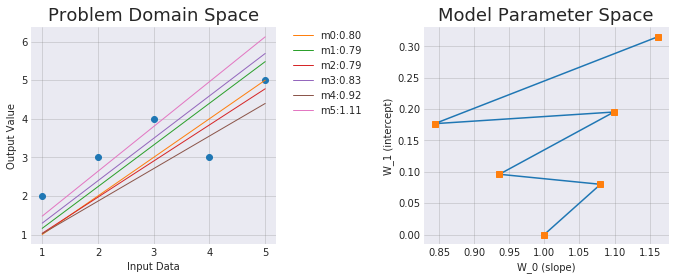

In [11]:
import numpy as np
import helperFunc, linRegFunc

#################### Demo Parameters #################### 
# TRY CHANGING THESE & SEE HOW IT AFFECTS OUR SEARCH
N_STEPS = 5
LEARNING_RATE = 0.1
ORIGINAL_MODEL = [1,0]
SHOW_CONTOURS = False

################### Gradient Update Demo #################### 
### Load & Pre-process Data
points = np.genfromtxt("fivePoints.csv", delimiter=',')
X = helperFunc.augment(points)[:,:2]
y = points[:,1]

### Perform GD Update & save intermediate model performance
models, loss = linRegFunc.GDUpdate(X, y, N_STEPS,
                                   ORIGINAL_MODEL, 
                                   LEARNING_RATE, 
                                   verbose = True)

### Display Results
print(f"\nSearched {len(models)} models...")
print(f"Best model: {models[np.argmin(loss)]}, Loss: {loss[np.argmin(loss)]}")
linRegFunc.plotGDProgress(points, models, loss,
                          show_contours = SHOW_CONTOURS)

 > __DISCUSSION QUESTIONS:__  
 * _Look closely at the loss for each model, what problem do you notice?_ 
 * _Use the Model Parameter Space view to explain why this problem might be occurring._ __HINT:__ Try `SHOW_CONTOURS = True`. _Based upon your insights, propose a solution to this problem._
 * _When performing GD 'in the wild' will we be able to visualize the error surface (eg. using contour lines, heatmaps or 3D plots)?_

## Demo : Stoichastic Gradient Descent

In full Gradient Descent (what we did above) we do a descent step only after the calculation of the gradient over the whole set of data. That means we only update the weight vector once each **epoch** (pass over the data) thus making one small but “good” step towards the minimum. However since gradient descent is an interative algorithm that requires many updates to find the minimum, with large datasets, waiting to process every record before performing an update can result in a slow and computationaly costly training process. 

The alternatives are:
1. **Stochastic GD** -- compute the gradient _with respect to a single point at a time_ and update the entire weight vector after each record. By the time we have seen the whole data set, we will have made N (num of observations), perhaps “not so good”, steps with a general trend towards the minimum. SGD will “zig-zag” towards the minimum and eventually oscillate around the minimum but never converge. The advantage of SGD is that we can make progress at every example - if the data is very large, we may only need 1 pass over the whole dataset.
2. **Mini-batch GD** -- compute the gradient _with respect to a small **batch** (size of $B$) of points at a time_ and update the entire weight vector after each batch. If we are smart about shuffling the data, this can reduce the “zig-zaging” because the points in a batch will temper each other's influence. This is especially advantageous for noisy data where a single point might result in a gradient update that is dramatically in the wrong direction for the rest of the data. For this reason, MBGD can potentially finish even faster than SGD. However MBGD is seldom used because finding the right hyper-parameter b is a pain (usually $B$ is not too big $-$ from 32 to 256). 


Other than the denominator in front, the loss function for SGD/MBGD should look very familiar (note that SGD is basically just the special case where $B = 1$):

\begin{equation}\tag{3.2}
\nabla f(\boldsymbol{\theta}) \approx \nabla_{\text{batch}\,\,} f(\boldsymbol{\theta}) = \frac{2}{B}\sum_{i=1}^{B}\left(\mathbf{x}'_{a_i}\cdot \boldsymbol{\theta} - y_{a_i}\right)\cdot \mathbf{x}'_{a_i}
\end{equation}

where $a_i$ is an array of indices of objects which are in this batch. After obtaining this gradient we do a descent step in this approximate direction and proceed to the next stage of batch descent.

> __A TASK FOR YOU:__ Perform 5 update steps of Stochastic Gradient Descent with batchsize = $1$ on our small data set. 
Recall that our initial parameters were:
$$ \boldsymbol{\theta} = \begin{bmatrix} 1 \ \quad 0 \ \end{bmatrix}$$  
> ... and we used a learning rate of $\boldsymbol{\eta} = 0.1$

($\eta$ is pronounced 'eh-ta', sometimes we also use $\alpha$, "apha" to denote learning rate, the two are equivalent)

Hand Calculations:

|  $x_j '$  | $y_j$ |   $\boldsymbol{\theta}\cdot\mathbf{x}'_j$ | $\frac{2}{n}\left[ \boldsymbol{\theta}\cdot\mathbf{x}'_j - y_j\right]\cdot\mathbf{x}'_j$ | $\eta \nabla_{\boldsymbol{\theta}} f$ | $\boldsymbol(\theta) - \eta \nabla_{\boldsymbol{\theta}} f $ |
|:----:|:-----:|:----------------:|:------------------------:|:--------------:|:-----------:|
|  input   | true y   |   predicted y   | gradient for this 'batch' | update | new parameters|
| $ \begin{bmatrix} 1 \\ 1 \\ \end{bmatrix}$   |  2   |                  |             
| $ \begin{bmatrix} 3 \\ 1 \\ \end{bmatrix}$   |  4   |                  |     
| $ \begin{bmatrix} 5 \\ 1 \\ \end{bmatrix}$   |  5   |                  |      
| $ \begin{bmatrix} 4 \\ 1 \\ \end{bmatrix}$   |  3   |                  |      
| $ \begin{bmatrix} 2 \\ 1 \\ \end{bmatrix}$   |  3   |                  |      

 > __DISCUSSION QUESTIONS:__  
 * _How does this result compare to our result from the hand calculations in the last section? What implications does this have for our quest to find the optimal paramters?_ 
 * _How will parallelizing Stoichastic Gradient Descent be similar/different to parallelizing regular GD?_ 

Model 0: [1.00, 0.00]
Loss: 0.8
     >>> gradient: [-0.4 -0.4]
     >>> update: [-0.04 -0.04]
Model 1: [1.04, 0.04]
Loss: 0.7648
     >>> gradient: [-1.008 -0.336]
     >>> update: [-0.1008 -0.0336]
Model 2: [1.14, 0.07]
Loss: 0.9141452800000004
     >>> gradient: [1.5552  0.31104]
     >>> update: [0.15552  0.031104]
Model 3: [0.99, 0.04]
Loss: 0.7782153256960003
     >>> gradient: [1.5737856 0.3934464]
     >>> update: [0.15737856 0.03934464]
Model 4: [0.83, 0.00]
Loss: 1.2577106818564097
     >>> gradient: [-1.07283661 -0.5364183 ]
     >>> update: [-0.10728366 -0.05364183]
Model 5: [0.94, 0.06]
Loss: 0.8337672467910437

Searched 6 models...
Best model: [1.04 0.04], Loss: 0.7648


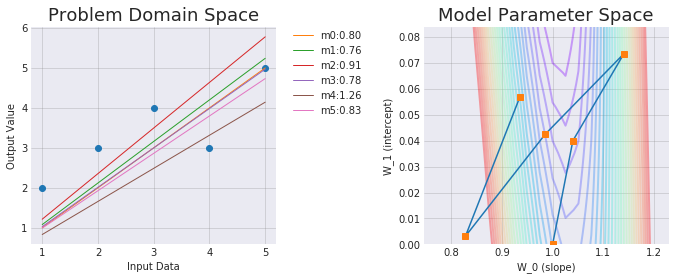

In [14]:
import helperFunc, linRegFunc

#################### Demo Parameters #################### 
# TRY CHANGING THESE & SEE HOW IT AFFECTS OUR SEARCH
N_STEPS = 5
BATCHSIZE = 1
LEARNING_RATE = 0.1
ORIGINAL_MODEL = [1,0]
SHOW_CONTOURS = True

################### Stoichastic GD Demo #################### 
### Load & Pre-process Data
points = np.genfromtxt("fivePoints.csv", delimiter=',')
X = helperFunc.augment(points)[:,:2]
y = points[:,1]

### Perform SGD Updates & save intermediate model performance
models, loss = linRegFunc.SGDUpdate(X, y, N_STEPS,
                                    BATCHSIZE,
                                    ORIGINAL_MODEL, 
                                    LEARNING_RATE, 
                                    verbose = True)

### Display Results
print(f"\nSearched {len(models)} models..." %())
print(f"Best model: {models[np.argmin(loss)]}, Loss: {loss[np.argmin(loss)]}")
linRegFunc.plotGDProgress(points, models, loss,
                          show_contours = SHOW_CONTOURS)

> __DISCUSSION QUESTIONS:__ 
* _At first glance does this seem to work as well as regular gradient descent? Why might our initial impression be deceiving?_ 
* _Does adjusting the batchsize and/or learning rate fix the problem that we're seeing?_
* _What do you notice about the direction of the first 3 updates? From the perspective of the first three points, what should our line look like?_
* _How does the scale of our data can impact the direction of our updates & time to convergence?_

__For more info, here are a few of rabbit holes:__
> https://arxiv.org/pdf/1707.00424.pdf   
> https://papers.nips.cc/paper/4390-hogwild-a-lock-free-approach-to-parallelizing-stochastic-gradient-descent.pdf
> http://papers.nips.cc/paper/4006-parallelized-stochastic-gradient-descent.pdf
> https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/distr_mini_batch.pdf

### That's it for today! 

#### Next week we will discuss...
* __L1 and L2 Regularization__ 
* __Common GD variants__
* __What to do if you can't compute a gradient for your loss function.__
* __Logistic Regression & classification__